In [33]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

In [34]:
clobber = True
path='data'
format='zarr'

## Get the model grid and generate region mask
Where we are using the [pop_tools](https://pop-tools.readthedocs.io/en/latest/examples/get-model-grid.html) package. This reads the same binary files that the model read to generate the grid online.

In [35]:
grid = pop_tools.get_grid('POP_gx1v6')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:         [384, 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

In [36]:
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
print(lat_slice)
grid = grid.isel(nlat=lat_slice)
grid

slice(0, 93, None)


<xarray.Dataset>
Dimensions:      (nlat: 93, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.082e+07
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.864e+06 5.864e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.085e+07
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.842e+06 5.842e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 6.339e+13
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 ... 35 44 49 52 53 53 53 54
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 6 6 6 6 6 6 6 6 6
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:         [384, 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

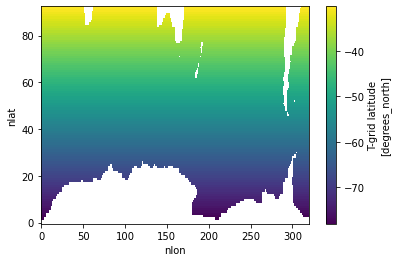

In [37]:
grid.TLAT.where(grid.KMT>0).plot();

In [38]:
# define a list of tuples describing our regions: (region_name, logical_array)
so_logic = (grid.TLAT <= -45)
mask_logic = [
    ('Southern Ocean', so_logic), 
    ('WAP & Atlantic', so_logic & ((grid.TLONG > 260) | (grid.TLONG < 25))),
#    ('Indo-Pacific', so_logic & ~((grid.TLONG > 260) | (grid.TLONG < 25))),    
]

# create a region coordinate with the region names
region = xr.DataArray(
    [t[0] for t in mask_logic], 
    dims=('region'), 
)
nregion = len(region)


# create a masked array array
masked_area = xr.DataArray(
    np.zeros((nregion,)+grid.TLAT.shape), 
    dims=('region',)+grid.TLAT.dims,
    coords={'region': region},
    name='masked_area',
)
for i, name_logic in enumerate(mask_logic):
    masked_area.data[i, :, :] = grid.TAREA.where(name_logic[1]).fillna(0.).where(grid.KMT>0)

# subset to the lat range from above
masked_area = masked_area.isel(nlat=lat_slice)

# dump a file for use elsewhere
if not os.path.exists('./data/region_mask.zarr'):
    masked_area.to_dataset().to_zarr('./data/region_mask.zarr')

masked_area    

<xarray.DataArray 'masked_area' (region: 2, nlat: 93, nlon: 320)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * region   (region) <U14 'Southern Ocean' 'WAP & Atlantic'
Dimensions without coordinates: nlat, nlon

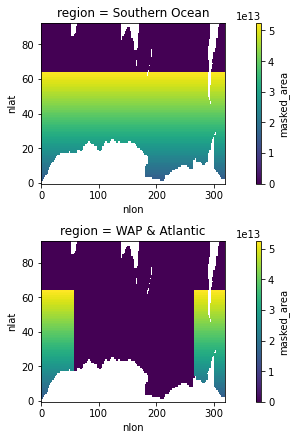

In [39]:
ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(masked_area.region.values):
    plt.axes(ax.ravel()[i])
    masked_area.sel(region=region).plot()    

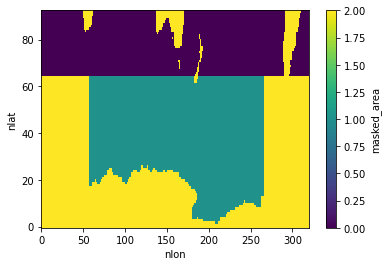

In [40]:
masked_area.where(masked_area==0).fillna(1.).sum('region').plot();

## Compute regional means

In [41]:
%%time
name = 'cesm-le-fields-djf-regional-timeseries'
if os.path.exists(f'{path}/{name}.{format}') and clobber:
    shutil.rmtree(f'{path}/{name}.{format}')
    
@xp.persist_ds(name=name, format=format, path=path, trust_cache=True, clobber=clobber)
def regional_means():
    
    ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
    
    dim = ['nlat', 'nlon']
    area_total = masked_area.sum(dim)
    weights = masked_area / area_total
    weights_sum = weights.sum(dim)

    # ensure that the weights add to 1.
    np.testing.assert_allclose(weights_sum.where(weights_sum != 0.).fillna(1.), 1.0, rtol=1e-7)

    with xr.set_options(keep_attrs=True):
        ds_djf_regional = (ds_djf[list(ds_djf.data_vars)] * weights).sum(dim).compute()

    return ds_djf_regional

ds_djf_regional = regional_means()
ds_djf_regional

writing cache file: data/cesm-le-fields-djf-regional-timeseries.zarr
CPU times: user 29.4 s, sys: 32.2 s, total: 1min 1s
Wall time: 42.9 s


<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, region: 2, time: 180)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * region         (region) <U14 'Southern Ocean' 'WAP & Atlantic'
Data variables:
    Chl_surf       (time, member_id, region) float64 0.7578 0.9736 ... 0.8742
    IFRAC          (time, member_id, region) float64 0.127 0.1598 ... 0.03969
    KGP            (time, length, member_id, region) float64 0.02197 ... -0.01734
    KGP_bias_corr  (time, length, member_id, region) float64 0.04556 ... -0.01615
    SST            (time, member_id, region) float64 4.613 4.226 ... 8.156 7.544
    SST_bias_corr  (time, member_id, region) float64 4.296 3.684 ... 6.531 5.898

## compute retrospective trends 

In [ ]:
%%time
# set up trend dimensions
trend_year = xr.DataArray(np.arange(1925, 2101, 1), dims=('time'))
trend_length = xr.DataArray([5, 10, 20, 60], dims=('trend_length'))

# loop over trends
ds_list = []
for end_year, n_year in product(trend_year.values, trend_length.values):

    # subset data for the time-period of this trend
    ds = ds_djf_regional.sel(time=slice(end_year-n_year+1, end_year))
    if len(ds.time) != n_year: 
        continue
        
    # loop over vars and compute trends
    da_list = []
    for v in ds.data_vars:
        da = util.linear_trend(
            ds[v]
        ).expand_dims(
            trend_length=[n_year], 
            trend_year=[end_year]
        ) * 10.
        da.attrs = ds[v].attrs
        da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
        da_list.append(da)
        
    ds_list.append(xr.merge(da_list))
    
ds_djf_rgn_trnd = xr.combine_by_coords(ds_list).compute()
ds_djf_rgn_trnd

## plot retrospective trends and ToE

In [ ]:
v = 'SST'
region = 'Southern Ocean'

hexcolor = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

fig = plt.figure(figsize=(6, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylabel('O$_2$ [mmol m$^{-3}$]')

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ax.plot(ds_djf_regional.time, var_i, '-', linewidth=0.5)
    
ax.plot(ds_djf_regional.time, ds_djf_regional[v].sel(region=region).mean('member_id'), '-', 
        linewidth=1, color='k')

ax.set_xticklabels([])
ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]')

ax = fig.add_subplot(gs[1, 0])
handles = []
for n_year in ds_djf_rgn_trnd.trend_length.values:
    da = ds_djf_rgn_trnd[v].sel(trend_length=n_year, region=region)
    
    y_mean = da.mean('member_id')
    y_std = da.std('member_id')
    
    y_low = y_mean - y_std
    y_hi = y_mean + y_std
    
    color = hexcolor.pop()
    
    p = ax.plot(
        ds_djf_rgn_trnd.trend_year, y_mean, 
        '-', label=f'{n_year:d} yr trends', color=color
    )
    handles.append(p[0])
    
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_low,
        '-', label='%d yr trends', color=color,
        linewidth=0.2
    )            
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_hi, 
        '-', label='%d yr trends', color=color, 
        linewidth=0.2
    )
    
    ax.fill_between(
        ds_djf_rgn_trnd.trend_year, y_low, y_hi,
        facecolor=color, alpha=0.4
    )
    

    s2n = y_mean / y_std
    for l in range(len(ds_djf_rgn_trnd.trend_year)):
        
        # where the signal to noise is greater than 2, detect!
        if all(np.abs(s2n[l:]) > 2):
            toex = ds_djf_rgn_trnd.trend_year.values[l]
            toey = y_mean.values[l]
            ax.plot(toex, toey, '*', 
                    color=color, 
                    markeredgecolor='k',
                    markeredgewidth=0.2,
                    markersize=10)
            break
            
ax.legend(handles, [h.get_label() for h in handles])
ax.axhline(0, color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel('Year')
ax.set_ylabel(f'{ds_djf_rgn_trnd[v].long_name} [{ds_djf_rgn_trnd[v].units}]')

gs.update(hspace=0.05)

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1 - 0.01
    x = p.x0 - 0.05
    fig.text(x, y, '%s'%alp[i],
             fontsize=14.,
             fontweight='semibold')

In [ ]:
for plot_region in masked_area.region.values:

    nvar = len(ds_djf_regional.data_vars)
    ncol = int(np.sqrt(nvar))
    nrow = int(nvar/ncol) + min(1, nvar%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                           constrained_layout=True)

    for i, v in enumerate(ds_djf_regional.data_vars):
        plt.axes(ax.ravel()[i])

        var = ds_djf_regional[v].sel(region=plot_region)
        if 'length' in var.dims:
            var = var.sel(length=40.)            
        for m_id in ds_djf_regional.member_id:
            var_i = var.sel(member_id=m_id)
            var_i.plot(linewidth=0.5)

        with xr.set_options(keep_attrs=True):            
            var.mean('member_id').plot(color='k', linewidth=1)
        plt.title(v)
    plt.suptitle(plot_region, fontsize=16, fontweight='bold')

## Compute temporal means

In [ ]:
%%time
name = 'cesm-le-fields-djf-epoch-mean'
if os.path.exists(f'{path}/{name}.{format}') and clobber:
    shutil.rmtree(f'{path}/{name}.{format}')
@xp.persist_ds(name=name, format=format, path=path, trust_cache=True, clobber=clobber)
def epoch_means():
    
    ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
    
    with xr.set_options(keep_attrs=True):   
        epoch_list = [
            ('1920-1950', ds_djf.sel(time=slice('1920', '1950')).mean('time')),
            ('2070-2100', ds_djf.sel(time=slice('2070', '2100')).mean('time')),
        ]

    epoch = xr.DataArray(
        [t[0] for t in epoch_list],
        dims=('epoch'),
        name='epoch',
    )    

    ds_djf_epoch = xr.concat(
        [t[1] for t in epoch_list], 
        dim=epoch,
    )
    return ds_djf_epoch.compute()
ds_djf_epoch = epoch_means()

In [ ]:
for epoch in ds_djf_epoch.epoch.values:

    nvar = len(ds_djf_epoch.data_vars)
    ncol = int(np.sqrt(nvar))
    nrow = int(nvar/ncol) + min(1, nvar%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                           constrained_layout=True)

    for i, v in enumerate(ds_djf_epoch.data_vars):
        plt.axes(ax.ravel()[i])

        with xr.set_options(keep_attrs=True):             
            var = ds_djf_epoch[v].sel(epoch=epoch).mean('member_id')
        if 'length' in var.dims:
            var = var.sel(length=40.)            
        var.plot()
        plt.title(v);
    plt.suptitle(epoch, fontsize=16, fontweight='bold');

In [ ]:
with xr.set_options(keep_attrs=True):  
    ds_djf_epoch_diff = ds_djf_epoch.diff('epoch').squeeze('epoch')
ds_djf_epoch_diff

In [ ]:
nvar = len(ds_djf_epoch_diff.data_vars)
ncol = int(np.sqrt(nvar))
nrow = int(nvar/ncol) + min(1, nvar%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, v in enumerate(ds_djf_epoch_diff.data_vars):
    plt.axes(ax.ravel()[i])

    with xr.set_options(keep_attrs=True):             
        var = ds_djf_epoch_diff[v].mean('member_id')
    if 'length' in var.dims:
        var = var.sel(length=40.)            
    var.plot()
    plt.title(v)

epoch = ds_djf_epoch.epoch.data
plt.suptitle(f'({epoch[1]}) - ({epoch[0]})', fontsize=16, fontweight='bold');